In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms,datasets
from torchvision.utils import make_grid

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.CIFAR10(root='../01-PyTorch-Basics',download=True,train=True,transform=transform)

Files already downloaded and verified


In [4]:
test_data = datasets.CIFAR10(root='../01-PyTorch-Basics',download=True,train=False,transform=transform)

Files already downloaded and verified


In [5]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../01-PyTorch-Basics
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../01-PyTorch-Basics
    Split: Test
    StandardTransform
Transform: ToTensor()

In [69]:
train_batch_size = 256
test_batch_size = 256
train_loader = DataLoader(train_data,train_batch_size,shuffle=True)
test_loader = DataLoader(test_data,test_batch_size,shuffle=False)

In [22]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

Label: [    9     2     1     1     3     7     6     4     2     0     7     3
     3     9     2     6     2     8     7     4     2     0     3     2
     1     3     4     6     9     5     9     4     2     5     2     5
     1     7     9     4     1     1     6     7     8     4     6     0
     0     1     2     6     0     1     0     0     9     7     1     2
     9     4     7     8]
Class:  truck  bird   car   car   cat horse  frog  deer  bird plane horse   cat   cat truck  bird  frog  bird  ship horse  deer  bird plane   cat  bird   car   cat  deer  frog truck   dog truck  deer  bird   dog  bird   dog   car horse truck  deer   car   car  frog horse  ship  deer  frog plane plane   car  bird  frog plane   car plane plane truck horse   car  bird truck  deer horse  ship


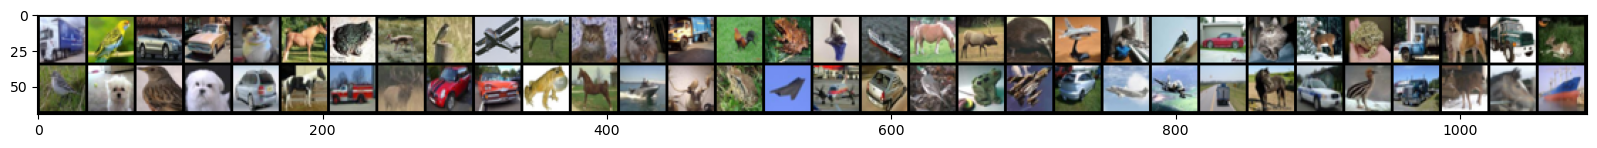

In [25]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=32)  # the default nrow is 8
plt.figure(figsize=(20,12))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [89]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=3,stride=1)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=3,stride=1)
        self.fc1 = nn.Linear(6*6*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self,x):
        #conv->relu->maxpool(2,2) repeat
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,576)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

In [71]:
device = torch.device("mps")

In [105]:
CNN = CNNModel().to(device)

In [106]:
num_epochs = 20
optimizer = torch.optim.Adam(CNN.parameters(),lr=0.005)
criterion = nn.CrossEntropyLoss()

In [107]:
import time
train_losses = []
start = time.time()
for epoch in range(num_epochs):
    for img,label in train_loader:
        img,label = img.to(device),label.to(device)
        y_pred = CNN(img)
        loss = criterion(y_pred,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())
    if (epoch+1)%10==0:
        print(f"epoch : {epoch+1} loss : {loss.item()}")
end = time.time()
print(f"{(end-start)/60} mins")

epoch : 10 loss : 0.820879340171814
epoch : 20 loss : 0.6431897282600403
0.679568596680959 mins


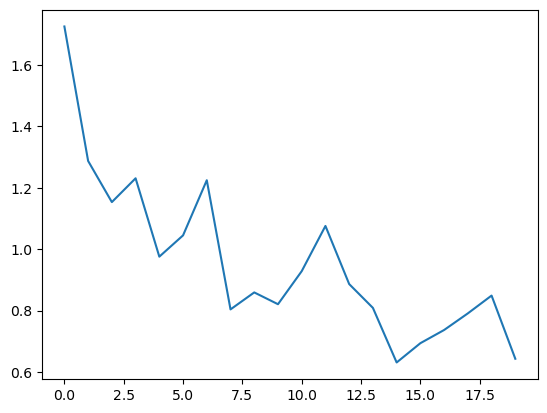

In [108]:
plt.plot(train_losses)

In [109]:
from sklearn.metrics import classification_report,accuracy_score
all_preds = []
all_labels = []

CNN.eval()
with torch.no_grad():
    for img, label in test_loader:
        img,label = img.to(device),label.to(device)
        pred = CNN(img)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(f" accuracy : {accuracy_score(all_labels, all_preds)}","\n")
print(classification_report(all_labels, all_preds))


 accuracy : 0.6168 

              precision    recall  f1-score   support

           0       0.64      0.66      0.65      1000
           1       0.76      0.72      0.74      1000
           2       0.55      0.42      0.48      1000
           3       0.41      0.49      0.45      1000
           4       0.53      0.56      0.54      1000
           5       0.54      0.51      0.52      1000
           6       0.75      0.68      0.71      1000
           7       0.66      0.72      0.69      1000
           8       0.68      0.78      0.73      1000
           9       0.69      0.63      0.66      1000

    accuracy                           0.62     10000
   macro avg       0.62      0.62      0.62     10000
weighted avg       0.62      0.62      0.62     10000



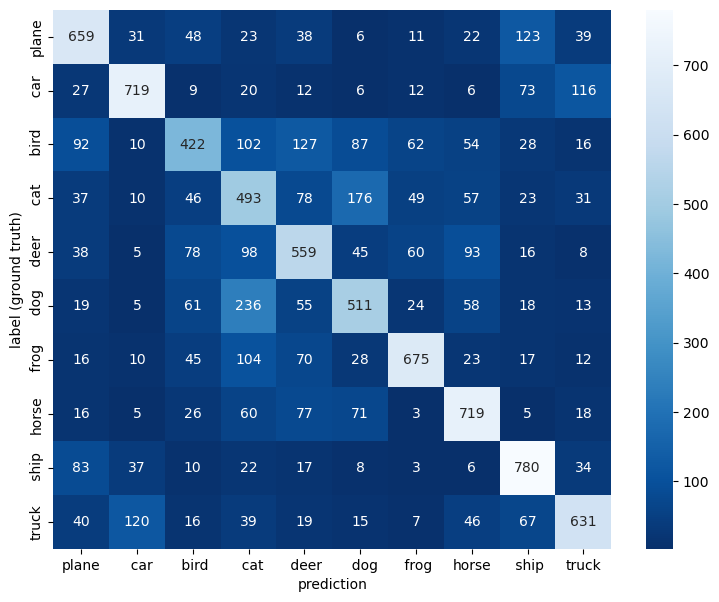

In [122]:
from sklearn.metrics import confusion_matrix
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_val = CNN(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1).cpu().numpy(), predicted.view(-1).cpu().numpy())
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues_r')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [144]:
class VGG6(nn.Module):
    def __init__(self):
        super(VGG6,self).__init__()
        self.conv1 = nn.Conv2d(3,16,3,1,padding=1)
        self.conv2 = nn.Conv2d(16,32,3,1,padding=1)
        self.conv3 = nn.Conv2d(32,64,3,1,padding=1)
        self.conv4 = nn.Conv2d(64,128,3,1,padding=1)
        self.conv5 = nn.Conv2d(128,256,3,1,padding=1)
        self.fc1 = nn.Linear(4*4*64,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,32)
        self.out = nn.Linear(32,10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,1024)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return F.log_softmax(x,dim=1)

In [145]:
vgg_model = VGG6().to(device)

In [146]:
import time
from tqdm import tqdm
num_epochs = 100
optimizer = torch.optim.Adam(vgg_model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

start = time.time()
for epoch in range(num_epochs):
    vgg_model.train()
    # Wrap your train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for img, label in pbar:
        img,label = img.to(device),label.to(device)
        optimizer.zero_grad()
        y_pred = vgg_model(img)
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()
        
        # Update total loss and progress bar
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/100: 100%|███████████████| 196/196 [00:04<00:00, 48.59it/s, loss=1.7392]


Epoch 1/100, Average Loss: 1.9244


Epoch 2/100: 100%|███████████████| 196/196 [00:03<00:00, 63.11it/s, loss=1.2817]


Epoch 2/100, Average Loss: 1.5561


Epoch 3/100: 100%|███████████████| 196/196 [00:03<00:00, 63.56it/s, loss=1.6113]


Epoch 3/100, Average Loss: 1.4285


Epoch 4/100: 100%|███████████████| 196/196 [00:03<00:00, 63.42it/s, loss=1.1763]


Epoch 4/100, Average Loss: 1.3352


Epoch 5/100: 100%|███████████████| 196/196 [00:03<00:00, 64.46it/s, loss=1.2563]


Epoch 5/100, Average Loss: 1.2491


Epoch 6/100: 100%|███████████████| 196/196 [00:03<00:00, 60.74it/s, loss=1.0746]


Epoch 6/100, Average Loss: 1.1746


Epoch 7/100: 100%|███████████████| 196/196 [00:03<00:00, 63.57it/s, loss=1.0352]


Epoch 7/100, Average Loss: 1.1000


Epoch 8/100: 100%|███████████████| 196/196 [00:03<00:00, 61.68it/s, loss=0.8914]


Epoch 8/100, Average Loss: 1.0424


Epoch 9/100: 100%|███████████████| 196/196 [00:03<00:00, 57.15it/s, loss=1.1300]


Epoch 9/100, Average Loss: 0.9904


Epoch 10/100: 100%|██████████████| 196/196 [00:03<00:00, 58.17it/s, loss=0.9027]


Epoch 10/100, Average Loss: 0.9568


Epoch 11/100: 100%|██████████████| 196/196 [00:03<00:00, 55.31it/s, loss=1.0491]


Epoch 11/100, Average Loss: 0.9112


Epoch 12/100: 100%|██████████████| 196/196 [00:03<00:00, 58.23it/s, loss=0.8975]


Epoch 12/100, Average Loss: 0.8840


Epoch 13/100: 100%|██████████████| 196/196 [00:03<00:00, 56.54it/s, loss=0.8644]


Epoch 13/100, Average Loss: 0.8553


Epoch 14/100: 100%|██████████████| 196/196 [00:03<00:00, 56.68it/s, loss=0.9614]


Epoch 14/100, Average Loss: 0.8223


Epoch 15/100: 100%|██████████████| 196/196 [00:03<00:00, 55.71it/s, loss=0.5759]


Epoch 15/100, Average Loss: 0.7846


Epoch 16/100: 100%|██████████████| 196/196 [00:03<00:00, 55.77it/s, loss=0.6409]


Epoch 16/100, Average Loss: 0.7661


Epoch 17/100: 100%|██████████████| 196/196 [00:03<00:00, 54.77it/s, loss=0.7213]


Epoch 17/100, Average Loss: 0.7315


Epoch 18/100: 100%|██████████████| 196/196 [00:03<00:00, 56.08it/s, loss=0.4233]


Epoch 18/100, Average Loss: 0.7054


Epoch 19/100: 100%|██████████████| 196/196 [00:03<00:00, 56.86it/s, loss=0.8216]


Epoch 19/100, Average Loss: 0.6933


Epoch 20/100: 100%|██████████████| 196/196 [00:03<00:00, 56.17it/s, loss=0.7164]


Epoch 20/100, Average Loss: 0.6679


Epoch 21/100: 100%|██████████████| 196/196 [00:03<00:00, 55.52it/s, loss=0.6921]


Epoch 21/100, Average Loss: 0.6456


Epoch 22/100: 100%|██████████████| 196/196 [00:03<00:00, 54.71it/s, loss=0.5329]


Epoch 22/100, Average Loss: 0.6203


Epoch 23/100: 100%|██████████████| 196/196 [00:03<00:00, 54.13it/s, loss=0.7219]


Epoch 23/100, Average Loss: 0.6088


Epoch 24/100: 100%|██████████████| 196/196 [00:03<00:00, 55.15it/s, loss=0.5426]


Epoch 24/100, Average Loss: 0.5794


Epoch 25/100: 100%|██████████████| 196/196 [00:03<00:00, 54.48it/s, loss=0.6074]


Epoch 25/100, Average Loss: 0.5623


Epoch 26/100: 100%|██████████████| 196/196 [00:03<00:00, 56.33it/s, loss=0.5382]


Epoch 26/100, Average Loss: 0.5462


Epoch 27/100: 100%|██████████████| 196/196 [00:03<00:00, 56.92it/s, loss=0.6315]


Epoch 27/100, Average Loss: 0.5234


Epoch 28/100: 100%|██████████████| 196/196 [00:03<00:00, 53.82it/s, loss=0.5330]


Epoch 28/100, Average Loss: 0.5123


Epoch 29/100: 100%|██████████████| 196/196 [00:03<00:00, 56.06it/s, loss=0.6190]


Epoch 29/100, Average Loss: 0.4941


Epoch 30/100: 100%|██████████████| 196/196 [00:03<00:00, 55.16it/s, loss=0.5354]


Epoch 30/100, Average Loss: 0.4734


Epoch 31/100: 100%|██████████████| 196/196 [00:03<00:00, 50.24it/s, loss=0.3779]


Epoch 31/100, Average Loss: 0.4641


Epoch 32/100: 100%|██████████████| 196/196 [00:03<00:00, 55.84it/s, loss=0.3870]


Epoch 32/100, Average Loss: 0.4430


Epoch 33/100: 100%|██████████████| 196/196 [00:03<00:00, 54.62it/s, loss=0.4491]


Epoch 33/100, Average Loss: 0.4301


Epoch 34/100: 100%|██████████████| 196/196 [00:03<00:00, 56.58it/s, loss=0.4346]


Epoch 34/100, Average Loss: 0.4152


Epoch 35/100: 100%|██████████████| 196/196 [00:03<00:00, 53.13it/s, loss=0.3995]


Epoch 35/100, Average Loss: 0.4059


Epoch 36/100: 100%|██████████████| 196/196 [00:03<00:00, 53.44it/s, loss=0.5031]


Epoch 36/100, Average Loss: 0.3921


Epoch 37/100: 100%|██████████████| 196/196 [00:03<00:00, 55.36it/s, loss=0.3469]


Epoch 37/100, Average Loss: 0.3609


Epoch 38/100: 100%|██████████████| 196/196 [00:03<00:00, 52.28it/s, loss=0.5135]


Epoch 38/100, Average Loss: 0.3527


Epoch 39/100: 100%|██████████████| 196/196 [00:03<00:00, 52.40it/s, loss=0.2646]


Epoch 39/100, Average Loss: 0.3430


Epoch 40/100: 100%|██████████████| 196/196 [00:03<00:00, 54.99it/s, loss=0.4502]


Epoch 40/100, Average Loss: 0.3294


Epoch 41/100: 100%|██████████████| 196/196 [00:03<00:00, 53.86it/s, loss=0.2482]


Epoch 41/100, Average Loss: 0.3082


Epoch 42/100: 100%|██████████████| 196/196 [00:03<00:00, 53.89it/s, loss=0.2514]


Epoch 42/100, Average Loss: 0.3097


Epoch 43/100: 100%|██████████████| 196/196 [00:03<00:00, 56.77it/s, loss=0.3102]


Epoch 43/100, Average Loss: 0.2909


Epoch 44/100: 100%|██████████████| 196/196 [00:03<00:00, 57.88it/s, loss=0.3876]


Epoch 44/100, Average Loss: 0.2824


Epoch 45/100: 100%|██████████████| 196/196 [00:03<00:00, 57.76it/s, loss=0.2149]


Epoch 45/100, Average Loss: 0.2689


Epoch 46/100: 100%|██████████████| 196/196 [00:03<00:00, 57.94it/s, loss=0.2620]


Epoch 46/100, Average Loss: 0.2552


Epoch 47/100: 100%|██████████████| 196/196 [00:03<00:00, 57.90it/s, loss=0.3497]


Epoch 47/100, Average Loss: 0.2598


Epoch 48/100: 100%|██████████████| 196/196 [00:03<00:00, 57.17it/s, loss=0.1510]


Epoch 48/100, Average Loss: 0.2342


Epoch 49/100: 100%|██████████████| 196/196 [00:03<00:00, 56.96it/s, loss=0.3308]


Epoch 49/100, Average Loss: 0.2189


Epoch 50/100: 100%|██████████████| 196/196 [00:03<00:00, 58.00it/s, loss=0.2346]


Epoch 50/100, Average Loss: 0.2287


Epoch 51/100: 100%|██████████████| 196/196 [00:03<00:00, 57.69it/s, loss=0.1015]


Epoch 51/100, Average Loss: 0.2035


Epoch 52/100: 100%|██████████████| 196/196 [00:03<00:00, 57.41it/s, loss=0.1263]


Epoch 52/100, Average Loss: 0.1965


Epoch 53/100: 100%|██████████████| 196/196 [00:03<00:00, 57.28it/s, loss=0.1922]


Epoch 53/100, Average Loss: 0.1857


Epoch 54/100: 100%|██████████████| 196/196 [00:03<00:00, 57.20it/s, loss=0.2409]


Epoch 54/100, Average Loss: 0.1753


Epoch 55/100: 100%|██████████████| 196/196 [00:03<00:00, 56.91it/s, loss=0.0648]


Epoch 55/100, Average Loss: 0.1826


Epoch 56/100: 100%|██████████████| 196/196 [00:03<00:00, 57.67it/s, loss=0.1999]


Epoch 56/100, Average Loss: 0.1709


Epoch 57/100: 100%|██████████████| 196/196 [00:03<00:00, 57.03it/s, loss=0.1592]


Epoch 57/100, Average Loss: 0.1606


Epoch 58/100: 100%|██████████████| 196/196 [00:03<00:00, 58.47it/s, loss=0.3328]


Epoch 58/100, Average Loss: 0.1725


Epoch 59/100: 100%|██████████████| 196/196 [00:03<00:00, 57.71it/s, loss=0.1654]


Epoch 59/100, Average Loss: 0.1594


Epoch 60/100: 100%|██████████████| 196/196 [00:03<00:00, 58.14it/s, loss=0.0843]


Epoch 60/100, Average Loss: 0.1367


Epoch 61/100: 100%|██████████████| 196/196 [00:03<00:00, 58.00it/s, loss=0.2777]


Epoch 61/100, Average Loss: 0.1430


Epoch 62/100: 100%|██████████████| 196/196 [00:03<00:00, 57.62it/s, loss=0.2280]


Epoch 62/100, Average Loss: 0.1363


Epoch 63/100: 100%|██████████████| 196/196 [00:03<00:00, 57.66it/s, loss=0.1612]


Epoch 63/100, Average Loss: 0.1278


Epoch 64/100: 100%|██████████████| 196/196 [00:03<00:00, 57.54it/s, loss=0.3000]


Epoch 64/100, Average Loss: 0.1338


Epoch 65/100: 100%|██████████████| 196/196 [00:03<00:00, 57.16it/s, loss=0.1885]


Epoch 65/100, Average Loss: 0.1392


Epoch 66/100: 100%|██████████████| 196/196 [00:03<00:00, 57.04it/s, loss=0.0871]


Epoch 66/100, Average Loss: 0.1268


Epoch 67/100: 100%|██████████████| 196/196 [00:03<00:00, 58.07it/s, loss=0.1448]


Epoch 67/100, Average Loss: 0.1001


Epoch 68/100: 100%|██████████████| 196/196 [00:03<00:00, 57.11it/s, loss=0.0959]


Epoch 68/100, Average Loss: 0.1199


Epoch 69/100: 100%|██████████████| 196/196 [00:03<00:00, 58.27it/s, loss=0.1385]


Epoch 69/100, Average Loss: 0.1225


Epoch 70/100: 100%|██████████████| 196/196 [00:03<00:00, 57.27it/s, loss=0.2062]


Epoch 70/100, Average Loss: 0.1081


Epoch 71/100: 100%|██████████████| 196/196 [00:03<00:00, 57.30it/s, loss=0.1314]


Epoch 71/100, Average Loss: 0.0895


Epoch 72/100: 100%|██████████████| 196/196 [00:03<00:00, 58.03it/s, loss=0.0260]


Epoch 72/100, Average Loss: 0.1030


Epoch 73/100: 100%|██████████████| 196/196 [00:03<00:00, 58.15it/s, loss=0.0739]


Epoch 73/100, Average Loss: 0.0859


Epoch 74/100: 100%|██████████████| 196/196 [00:03<00:00, 57.85it/s, loss=0.1170]


Epoch 74/100, Average Loss: 0.0842


Epoch 75/100: 100%|██████████████| 196/196 [00:03<00:00, 58.26it/s, loss=0.0825]


Epoch 75/100, Average Loss: 0.1107


Epoch 76/100: 100%|██████████████| 196/196 [00:03<00:00, 58.62it/s, loss=0.1161]


Epoch 76/100, Average Loss: 0.0875


Epoch 77/100: 100%|██████████████| 196/196 [00:03<00:00, 58.69it/s, loss=0.0822]


Epoch 77/100, Average Loss: 0.0846


Epoch 78/100: 100%|██████████████| 196/196 [00:03<00:00, 58.26it/s, loss=0.1043]


Epoch 78/100, Average Loss: 0.0819


Epoch 79/100: 100%|██████████████| 196/196 [00:03<00:00, 58.25it/s, loss=0.1363]


Epoch 79/100, Average Loss: 0.0993


Epoch 80/100: 100%|██████████████| 196/196 [00:03<00:00, 58.43it/s, loss=0.1939]


Epoch 80/100, Average Loss: 0.1018


Epoch 81/100: 100%|██████████████| 196/196 [00:03<00:00, 58.46it/s, loss=0.0724]


Epoch 81/100, Average Loss: 0.1086


Epoch 82/100: 100%|██████████████| 196/196 [00:03<00:00, 58.52it/s, loss=0.0592]


Epoch 82/100, Average Loss: 0.0868


Epoch 83/100: 100%|██████████████| 196/196 [00:03<00:00, 58.52it/s, loss=0.0818]


Epoch 83/100, Average Loss: 0.0452


Epoch 84/100: 100%|██████████████| 196/196 [00:03<00:00, 57.85it/s, loss=0.1512]


Epoch 84/100, Average Loss: 0.0697


Epoch 85/100: 100%|██████████████| 196/196 [00:03<00:00, 58.05it/s, loss=0.2612]


Epoch 85/100, Average Loss: 0.0929


Epoch 86/100: 100%|██████████████| 196/196 [00:03<00:00, 57.94it/s, loss=0.0807]


Epoch 86/100, Average Loss: 0.0998


Epoch 87/100: 100%|██████████████| 196/196 [00:03<00:00, 57.41it/s, loss=0.0224]


Epoch 87/100, Average Loss: 0.0760


Epoch 88/100: 100%|██████████████| 196/196 [00:03<00:00, 57.85it/s, loss=0.1075]


Epoch 88/100, Average Loss: 0.0580


Epoch 89/100: 100%|██████████████| 196/196 [00:03<00:00, 57.83it/s, loss=0.1159]


Epoch 89/100, Average Loss: 0.0616


Epoch 90/100: 100%|██████████████| 196/196 [00:03<00:00, 57.96it/s, loss=0.0926]


Epoch 90/100, Average Loss: 0.0830


Epoch 91/100: 100%|██████████████| 196/196 [00:03<00:00, 58.38it/s, loss=0.3002]


Epoch 91/100, Average Loss: 0.0931


Epoch 92/100: 100%|██████████████| 196/196 [00:03<00:00, 57.58it/s, loss=0.1442]


Epoch 92/100, Average Loss: 0.0803


Epoch 93/100: 100%|██████████████| 196/196 [00:03<00:00, 58.01it/s, loss=0.0556]


Epoch 93/100, Average Loss: 0.0546


Epoch 94/100: 100%|██████████████| 196/196 [00:03<00:00, 58.15it/s, loss=0.0214]


Epoch 94/100, Average Loss: 0.0880


Epoch 95/100: 100%|██████████████| 196/196 [00:03<00:00, 57.76it/s, loss=0.0142]


Epoch 95/100, Average Loss: 0.0498


Epoch 96/100: 100%|██████████████| 196/196 [00:03<00:00, 58.34it/s, loss=0.0707]


Epoch 96/100, Average Loss: 0.0521


Epoch 97/100: 100%|██████████████| 196/196 [00:03<00:00, 57.57it/s, loss=0.0593]


Epoch 97/100, Average Loss: 0.0615


Epoch 98/100: 100%|██████████████| 196/196 [00:03<00:00, 57.64it/s, loss=0.1648]


Epoch 98/100, Average Loss: 0.0787


Epoch 99/100: 100%|██████████████| 196/196 [00:03<00:00, 57.71it/s, loss=0.1036]


Epoch 99/100, Average Loss: 0.0961


Epoch 100/100: 100%|█████████████| 196/196 [00:03<00:00, 58.48it/s, loss=0.2602]

Epoch 100/100, Average Loss: 0.0579
Total training time: 5.72 minutes


In [147]:
from sklearn.metrics import classification_report,accuracy_score
all_preds = []
all_labels = []

vgg_model.eval()
with torch.no_grad():
    for img, label in test_loader:
        img,label = img.to(device),label.to(device)
        pred = vgg_model(img)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(f" accuracy : {accuracy_score(all_labels, all_preds)}","\n")
print(classification_report(all_labels, all_preds))


 accuracy : 0.7034 

              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1000
           1       0.83      0.79      0.81      1000
           2       0.65      0.57      0.61      1000
           3       0.48      0.57      0.52      1000
           4       0.69      0.63      0.66      1000
           5       0.60      0.61      0.60      1000
           6       0.76      0.76      0.76      1000
           7       0.71      0.78      0.74      1000
           8       0.85      0.81      0.83      1000
           9       0.76      0.79      0.77      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000

